<a href="https://colab.research.google.com/github/shesshirley/Goldman-Analysis/blob/main/Goldman_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/datathon'

Mounted at /content/drive
/content/drive/Shared drives/datathon


In [ ]:
import pandas as pd
import numpy as np

# Data Collection

In [ ]:
#using get query to save datasets and read into dataframes
stock_df = pd.read_csv("stock_history.csv")
env_df = pd.read_csv("env_data.csv")
company_df = pd.read_csv("company_profile.csv")

# Data Analysis
### Data Pre-Processing

In [ ]:
#drop the useless column and keep the valuable feature for later predicting, pre-process the date column and filter out the date before 1980
stock_df1 = stock_df.copy()
stock_df1 = stock_df1.drop(columns="ID")
stock_df1['DATE'] = pd.to_datetime(stock_df1['DATE']).dt.year
stock_df1 = stock_df1.rename(columns={'DATE':'YEAR'})
stock_df1 = stock_df1[stock_df1["YEAR"]>=1980] 
stock_df1.head(2)

,SYMBOL,YEAR,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJCLOSE
9,BB,2020,4.97,5.16,4.81,4.84,5361500.0,4.84
10,BB,2020,5.38,5.43,5.16,5.21,5690900.0,5.21


In [ ]:
env_df1 = env_df.copy()
env_df1 = env_df1[['Country ISO Code', \
       'Indicator', 'Description','Year', 'Unit','Value']]
env_df1 = env_df1[env_df1["Year"]>=1980]
env_df1.head(2)

,Country ISO Code,Indicator,Description,Year,Unit,Value
10,AE,CO2 emissions,Carbon dioxide emissions are those stemming fr...,1980,Mton CO2,41.11924
11,AE,CO2 emissions,Carbon dioxide emissions are those stemming fr...,1981,Mton CO2,38.04811


In [ ]:
company_df1 = company_df.copy()
company_df1 = company_df1[['ID', 'SYMBOL', 'PRICE', 'BETA', 'VOLAVG', 'MKTCAP', 'LASTDIV', 'RANGE',
       'CHANGES', 'COMPANYNAME', 'INDUSTRY', 'SECTOR', 'DCFDIFF', 'DCF']]
company_df1.head(2)

,ID,SYMBOL,PRICE,BETA,VOLAVG,MKTCAP,LASTDIV,RANGE,CHANGES,COMPANYNAME,INDUSTRY,SECTOR,DCFDIFF,DCF
0,4276,GDP,8.61,2.26205,23768.0,108966432.0,0.00,2.395-11.71,0.27,Goodrich Petroleum Corp,Oil & Gas E&P,Energy,632.38,8.4445
1,4277,RFIL,4.47,0.92337,40537.0,43678692.0,0.08,3.31-7.38,0.01,RF Industries Ltd,Electrical Equipment & Parts,Industrials,NaN,5.7325


### Data Remaking

In [ ]:
#get the sum of the MKTCAP for each industry
company_grouped_df = company_df1.groupby('INDUSTRY')[['MKTCAP']].sum().reset_index()
company_grouped_df.head(2)

,INDUSTRY,MKTCAP
0,Advertising Agencies,4.952692e+10
1,Aerospace & Defense,9.323847e+11


In [ ]:
#get the mean close value of each symbol in each year
stock_year_df = stock_df1.groupby(['SYMBOL', 'YEAR'])[['CLOSE']].mean().reset_index()
stock_year_df.head(2)

,SYMBOL,YEAR,CLOSE
0,2CRSI.PA,2018,9.478593
1,2CRSI.PA,2019,7.957656


In [ ]:
#calculate the Market Price for each company by multuplying the close value and mktcap
stock_year_df2 = pd.merge(stock_year_df, company_df1[['SYMBOL', 'MKTCAP']], on = 'SYMBOL', how = 'left')
stock_year_df2['MPRICE'] = stock_year_df2['CLOSE'] * stock_year_df2['MKTCAP']
stock_year_df2.head(2)

,SYMBOL,YEAR,CLOSE,MKTCAP,MPRICE
0,2CRSI.PA,2018,9.478593,47024840.0,4.457293e+08
1,2CRSI.PA,2019,7.957656,47024840.0,3.742075e+08


In [ ]:
#merge table according to the company name to get the a overview of the industry price of each industry
stock_year_df3 = stock_year_df2.merge(company_df[['SYMBOL', 'INDUSTRY']], on = 'SYMBOL')
stock_year_df3 = stock_year_df3.groupby(['YEAR','INDUSTRY'])[['MKTCAP','MPRICE']].sum().reset_index()
stock_year_df3['INDUSTRY_PRICE'] = stock_year_df3['MPRICE']/stock_year_df3['MKTCAP']
stock_year_df3 = stock_year_df3[['YEAR', 'INDUSTRY','INDUSTRY_PRICE']]
stock_year_df3.head(2)

,YEAR,INDUSTRY,INDUSTRY_PRICE
0,1980,Advertising Agencies,0.469291
1,1980,Aerospace & Defense,1.172785


In [ ]:
#pick one specific indicator to do the data analysis
env_df2 = env_df1[env_df1['Indicator']=='CO2 emissions']
env_df2 = env_df2.groupby('Year')[['Value']].mean().reset_index()
env_df2 = env_df2.rename(columns = {'Year' : 'YEAR'})
env_df2.head(2)

,YEAR,Value
0,1980,99.954698
1,1981,98.273378


In [ ]:
#get the correlation of the chosen indicator with each industry, the aim is to find the most related industry accoridng to the indicator
industry_lst = list(set(stock_year_df3['INDUSTRY']))
industry_lst2 = []
corr_lst = []
for industry in industry_lst:
  temp_df = stock_year_df3[stock_year_df3['INDUSTRY'] == industry]
  temp_df = temp_df.merge(env_df2, on='YEAR')
  temp_df = temp_df.dropna()
  if temp_df.shape[0] < 5:
    continue;
  industry_lst2.append(industry)
  corr_lst.append(temp_df['INDUSTRY_PRICE'].corr(temp_df['Value']))

In [ ]:
#show the corr matrix for chosen indicator
corr_df = pd.DataFrame()
corr_df['Industry'] = industry_lst2
corr_df['corr'] = corr_lst
corr_df = corr_df.set_index('Industry')
corr_df = corr_df.sort_values(by='corr', ascending=False)
corr_df

,corr
Industry,
Oil & Gas Integrated,0.980198
Utilities Regulated,0.975174
Utilities Diversified,0.969857
Asset Management,0.961030
Department Stores,0.958648
...,...
Real Estate,-0.771051
Property Management,-0.827394
Apparel Stores,-0.832323


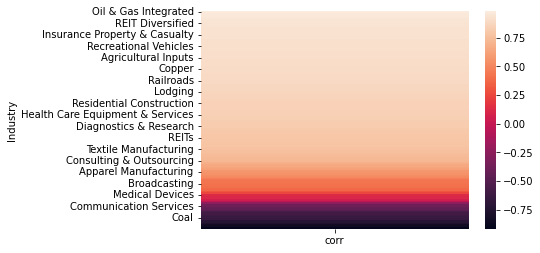

In [ ]:
#check the heatmap
import seaborn as sns
sns.heatmap(corr_df)

# Data Modeling
### Data Pre-Processing

In [ ]:
env_df3 = env_df1.groupby(['Year', 'Indicator']).Value.mean().unstack()
env_df4 = env_df3.copy()
for i in env_df4.columns:
  if env_df4[i].isna().sum() > 10:
   env_df4 = env_df4.drop(i,axis=1)
env_df4 = env_df4.reset_index()

In [ ]:
company_df2=company_df1[company_df1['INDUSTRY']=='Oil & Gas Integrated']

In [ ]:
stock_df2 = stock_df1.merge(company_df2, on='SYMBOL', how='inner')

In [ ]:
stock_df3 = stock_df2.groupby('YEAR')[['SYMBOL', 'OPEN', 'HIGH', 'LOW', 'VOLUME', 'ADJCLOSE',
       'MKTCAP', 'LASTDIV', 'RANGE', 'CHANGES','CLOSE']].mean().reset_index().rename(columns={'YEAR':'Year'})

In [ ]:
df = env_df4.merge(stock_df3, on='Year')
df.head()

,Year,Agricultural methane emissions,Agricultural nitrous oxide emissions,CO2 emissions,CO2 emissions from bunker fuels,CO2 emissions from cement production,CO2 emissions from electricity production (%),CO2 emissions from fossil-fuels,CO2 emissions from gas flaring,CO2 emissions from gas fuel consumption,CO2 emissions from gaseous fuel consumption,CO2 emissions from gaseous fuel consumption (%),CO2 emissions from liquid fuel consumption,CO2 emissions from liquid fuel consumption (%),CO2 emissions from manufacturing industries (%),CO2 emissions from other sectors (%),CO2 emissions from solid fuel consumption,CO2 emissions from solid fuel consumption (%),CO2 emissions intensity,CO2 emissions per capita,CO2 emissions: residential buildings (%),CO2 emissions: transport (%),CO2 intensity,Methane emissions,Methane emissions in energy sector,Nitrous oxide emissions,Nitrous oxide emissions in energy,Other greenhouse gas emissions,OPEN,HIGH,LOW,VOLUME,ADJCLOSE,MKTCAP,LASTDIV,CHANGES,CLOSE
0,1980,15589.587600,7963.209203,99.954698,672.548387,544.167742,28.919077,23116.135484,514.406452,3172.929032,15963.528181,6.111742,30308.889152,73.875675,24.756069,5.360065,23973.752873,12.360296,NaN,3.597459,11.683461,29.260161,2.381464,31702.128570,9027.940920,14234.023368,967.738977,27363.863531,-1.891075,3.063456,2.713677,1.206871e+06,2.898938,5.469026e+10,2.363024,0.528351,2.898938
1,1981,15362.547149,7722.499702,98.273378,613.698718,544.974359,29.330255,22415.038462,373.371795,3147.679487,16245.062106,6.576686,28901.001070,74.120811,24.466230,5.211043,23728.709601,12.352755,NaN,3.366222,11.511598,29.469466,2.255892,30961.869737,8766.730423,13730.248942,966.528692,24708.484510,-2.699650,4.495692,4.055540,1.072263e+06,4.265532,5.239872e+10,2.310522,0.507596,4.265532
2,1982,15583.616547,8107.843561,97.322670,550.089744,553.891026,29.994226,22249.884615,372.532051,2985.141026,15928.600006,6.534829,28335.016326,73.723849,23.848597,5.122822,24272.163241,12.863696,NaN,3.279952,11.368081,29.672707,2.201325,33170.177151,8948.994438,14621.440507,977.681023,33493.073572,-0.541372,1.019723,0.839643,1.282910e+06,0.919236,4.890537e+10,2.202792,0.449316,0.919236
3,1983,15538.441701,8187.663425,98.219654,534.314103,576.102564,30.614523,22539.294872,335.057692,2950.487179,16172.363831,6.871939,28184.736209,73.224936,23.455904,5.346545,25084.158111,13.343925,NaN,3.206057,10.972519,29.604429,2.207765,32381.752121,9102.710237,14490.029081,990.926341,30963.953635,-0.516075,0.942810,0.795825,1.290028e+06,0.864169,4.648319e+10,2.147214,0.413779,0.864169
4,1984,15399.426392,8128.191671,101.592149,537.705128,600.019231,30.983501,23391.294872,289.608974,3190.929487,17511.758500,7.445518,28333.707665,72.234575,23.235636,5.074744,26213.678472,13.937733,NaN,3.317016,11.245804,29.432518,2.159745,31570.347113,9288.016955,14039.189785,1010.309296,23409.797339,-0.221481,0.791030,0.673204,1.353418e+06,0.729626,4.716864e+10,2.165933,0.423669,0.729626


In [ ]:
df.isna().sum()

Year                                                0
Agricultural methane emissions                      1
Agricultural nitrous oxide emissions                1
CO2 emissions                                       0
CO2 emissions from bunker fuels                     5
CO2 emissions from cement production                5
CO2 emissions from electricity production (%)       5
CO2 emissions from fossil-fuels                     5
CO2 emissions from gas flaring                      5
CO2 emissions from gas fuel consumption             5
CO2 emissions from gaseous fuel consumption         3
CO2 emissions from gaseous fuel consumption (%)     3
CO2 emissions from liquid fuel consumption          3
CO2 emissions from liquid fuel consumption (%)      3
CO2 emissions from manufacturing industries (%)     5
CO2 emissions from other sectors (%)                5
CO2 emissions from solid fuel consumption           3
CO2 emissions from solid fuel consumption (%)       3
CO2 emissions intensity     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

train_X, test_X, train_y,  test_y = train_test_split(X, y, random_state=0)

In [ ]:
# Data imputation
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_X_imp = imp_mean.fit_transform(train_X)
test_X_imp = imp_mean.transform(test_X)

In [ ]:
# Data normalization
transformer = Normalizer()
train_X_trans = transformer.fit_transform(train_X_imp)
test_X_trans = transformer.transform(test_X_imp)

### SVM regression

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVR()
svr.fit(train_X_trans, train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
 svr.score(train_X_trans,train_y)

-0.23544499424394671

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
train_X_po = poly.fit_transform(train_X_trans)
test_X_po = poly.transform(test_X_trans)
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train_X_po,train_y)
reg.score(test_X_po, test_y)

0.9944645529887056

The result is overfitting which may causing by the data leakage when dealing with the date column and the open value of the stock. We will try to find a new way to clean data in Goldman Modeling.ipynb.